In [4]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from math import ceil
from IPython import display

/usr/lib/python3/dist-packages/Crypto/Random/Fortuna/FortunaGenerator.py:28: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if sys.version_info[0] is 2 and  sys.version_info[1] is 1:
/usr/lib/python3/dist-packages/Crypto/Random/Fortuna/FortunaGenerator.py:28: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if sys.version_info[0] is 2 and  sys.version_info[1] is 1:


In [5]:
# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-50oebr97
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=153797 sha256=c5fcd45c2f0a04d2908361275feddcad6f28ed667befdd9ba8f378863bbb86cb
  Stored in directory: /tmp/pip-ephem-wheel-cache-690utakt/wheels/3b/ee/a2/ab4d36a9a4af495bcb936f3e849d4b497b65fa40548a68d6c3
Successfully built tensorflow-docs
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [30]:
BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, '..', 'data')
file_paths = glob.glob(os.path.join(DATA_DIR, 'extraValid', '*.png'))

In [31]:
train_images = []
for image in file_paths:
    image_np = mpimg.imread(image).reshape(320, 320, 1).astype('float32')
    train_images.append(image_np)

In [26]:
BUFFER_SIZE = len(file_paths)
BATCH_SIZE = 32

In [68]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [7]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(80*80*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((80, 80, 256)))
    assert model.output_shape == (None, 80, 80, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 80, 80, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 160, 160, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 320, 320, 1) #Need to make 320x320x1

    return model

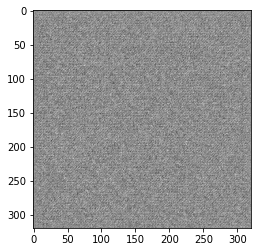

In [8]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [9]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[320, 320, 1])) #Need to make 320, 320, 1
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [10]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00033818]], shape=(1, 1), dtype=float32)


In [11]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [12]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [13]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [14]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [15]:
checkpoint_dir = os.path.join(DATA_DIR, 'checkpoints')
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [16]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [17]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [18]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        
        step_counter = 0
        percent_marker = ceil(len(dataset) / 10)
        for image_batch in dataset:
            step_counter += 1
            train_step(image_batch)
            if step_counter % percent_marker == 0:
                print(f'{int(step_counter / percent_marker) * 10}% of epoch')

        # Produce images for the GIF as you go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epochs,
                             seed)

In [19]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

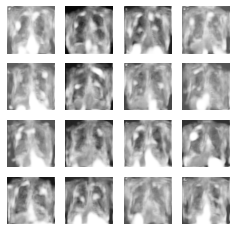

In [72]:
train(train_dataset, EPOCHS)

In [20]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [74]:
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

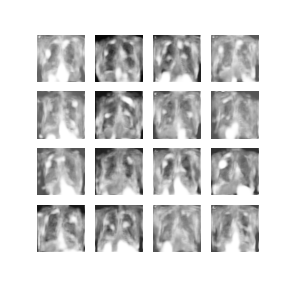

In [76]:
display_image(EPOCHS)

In [77]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)


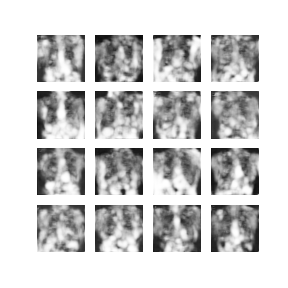

In [78]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

In [23]:
# Generate and save single image
def generate_and_save_image(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    prediction = model(test_input, training=False)
    
    plt.imshow(prediction[0, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')

    #plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [33]:
generate_and_save_image(generator, 1, train_images[0])


InvalidArgumentError: Matrix size-incompatible: In[0]: [320,320], In[1]: [100,1638400] [Op:MatMul]

<tf.Tensor: shape=(16, 100), dtype=float32, numpy=
array([[ 1.3898599 , -1.6242682 ,  0.89257425, ...,  0.3294315 ,
         0.08305575, -1.485348  ],
       [-1.2497363 ,  0.66571033, -0.08442155, ...,  0.03517625,
         1.0754187 , -0.16656457],
       [-1.1898553 ,  0.13854581,  0.00847561, ...,  0.27877054,
        -0.8529659 , -0.64274526],
       ...,
       [-0.49099544, -1.2705642 , -1.0310307 , ...,  0.03603853,
        -0.4439024 , -0.7519172 ],
       [-0.02751158, -0.0216885 ,  0.6980236 , ..., -0.11322353,
         0.4490019 ,  0.4710621 ],
       [-0.42015982, -0.6117499 ,  1.0111415 , ...,  1.5552505 ,
        -0.01994843,  1.189068  ]], dtype=float32)>